✓ torch_tensorrt imported successfully.
Primary benchmark device: cuda
CUDA Device: NVIDIA GeForce RTX 3070 Ti

--- Verifying Model Paths ---
✓ Found model file for 'baseline_resnet18'
✓ Found model file for 'distilled_ptq_perchannel'
✓ Found model file for 'distilled_ptq_pertensor'
✓ Found model file for 'distilled_qat'
✓ Found model file for 'distilled_trt_fp32'
✓ Found model file for 'distilled_trt_fp16'
🚀 Starting Comprehensive ResNet-18 Optimization Comparison

           REGISTERING BENCHMARK JOBS
  -> Loading baseline ResNet-18 model resnet18_baseline_ft_imagenetmini_final.pth...
✓ Registered job: ResNet-18 Baseline (FP32) - CPU
✓ Registered job: ResNet-18 Baseline (FP32) - GPU
  -> Loading JIT model model_final.pth...
✓ Registered job: Distilled PTQ Per-Channel INT8 - CPU
  -> Loading JIT model model_final.pth...
✓ Registered job: Distilled PTQ Per-Tensor INT8 - CPU
  -> Loading JIT model model_final.pth...
✓ Registered job: Distilled QAT INT8 - CPU
  -> Loading JIT model resne

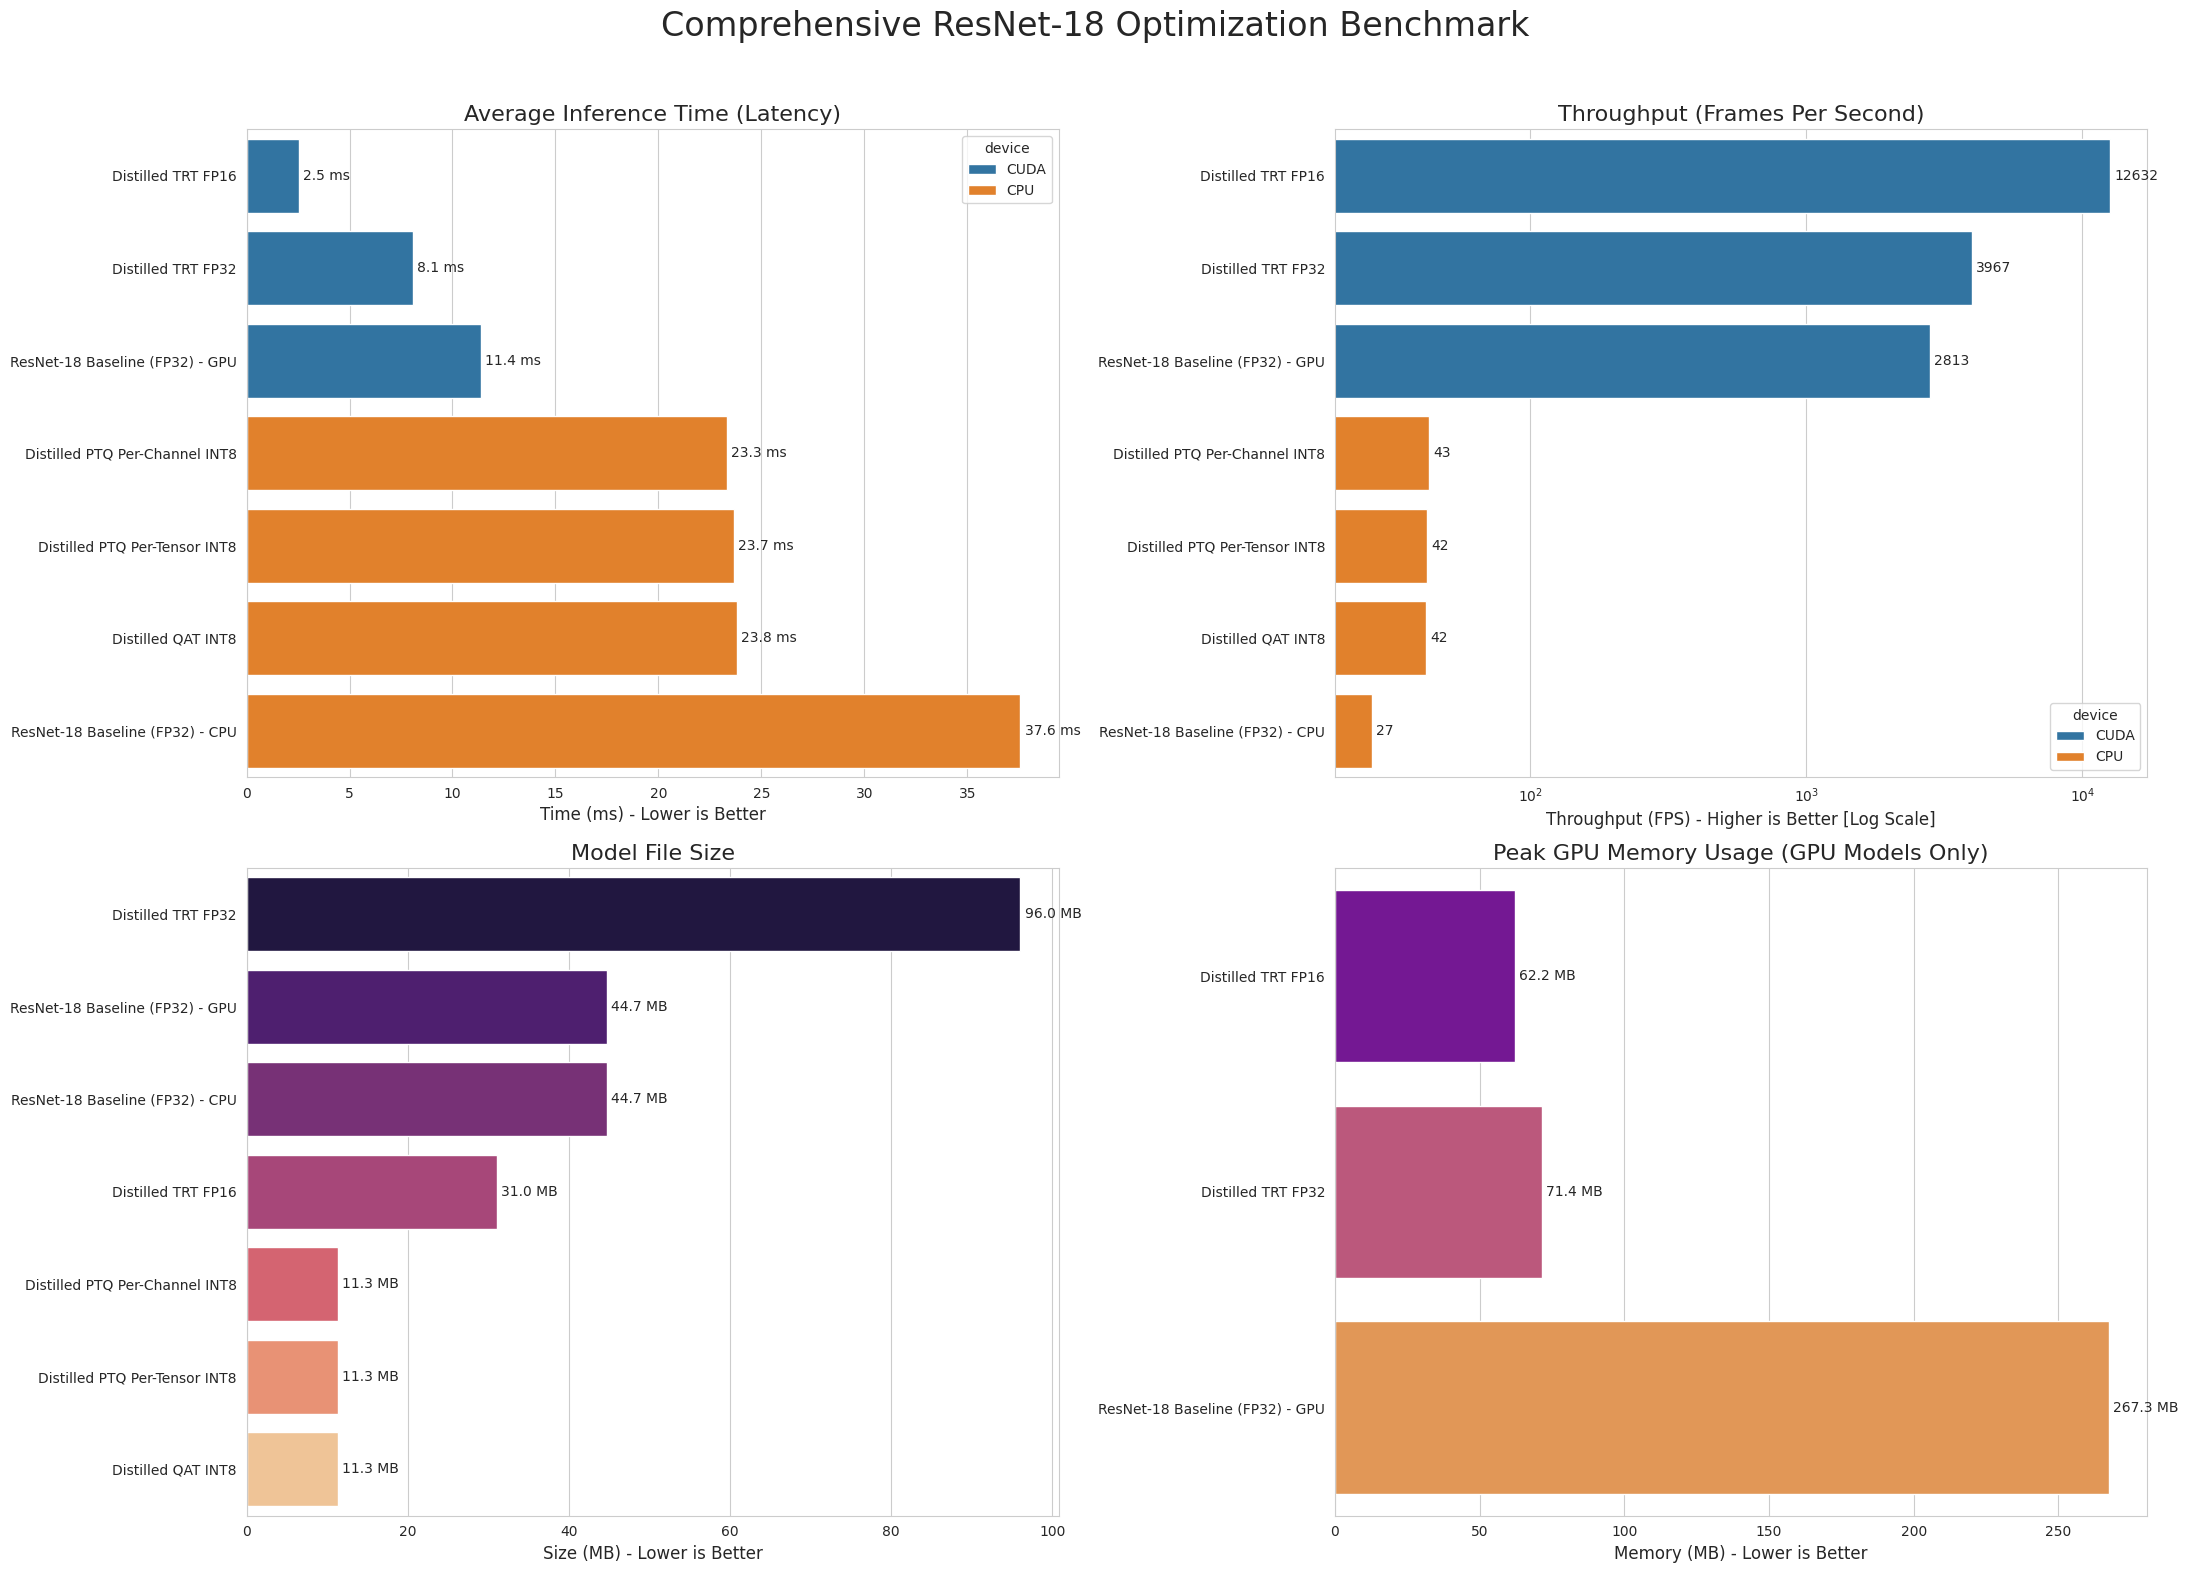


                                                              📋 COMPREHENSIVE OPTIMIZATION SUMMARY                                                              
                          Model Device  Batch Size  Latency (ms)  Throughput (FPS)  Size (MB)  GPU Mem (MB)  Speedup vs GPU Baseline  Speedup vs CPU Baseline  Compression
             Distilled TRT FP16   CUDA          32          2.53          12631.79      31.02         62.25                     4.49                    14.84         1.44
             Distilled TRT FP32   CUDA          32          8.07           3967.32      96.01         71.43                     1.41                     4.66         0.47
ResNet-18 Baseline (FP32) - GPU   CUDA          32         11.37           2813.36      44.67        267.31                     1.00                     3.30         1.00
 Distilled PTQ Per-Channel INT8    CPU           1         23.34             42.85      11.30          0.00                     0.49                     1

In [1]:
# %%
# ===================================================================
#                      IMPORTS AND SETUP
# ===================================================================
import torch
import torch.nn as nn
import torchvision.models as models
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import gc
from pathlib import Path

try:
    import torch_tensorrt
    print("✓ torch_tensorrt imported successfully.")
except ImportError:
    print("✗ WARNING: torch_tensorrt is not installed. TensorRT models will fail to load.")

sns.set_style("whitegrid")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Primary benchmark device: {DEVICE}")
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")

# %%
# ===================================================================
#                           MODEL PATHS
# ===================================================================
# Define paths as they exist INSIDE the container.
BASE_DIR = Path('/workspace')
SAVED_MODELS_DIR = BASE_DIR / 'saved_models_and_logs'

# --- ‼️ UPDATED FOR ALL RESNET-18 VARIANTS ‼️ ---
MODEL_PATHS = {
    # Baseline Model
    'baseline_resnet18': SAVED_MODELS_DIR / 'resnet18_baseline' / 'resnet18_baseline_ft_imagenetmini_final.pth',
    
    # Distilled + Quantized Models (INT8)
    'distilled_ptq_perchannel': SAVED_MODELS_DIR / 'combined_distilled_quantized' / 'resnet18pretrained_distilled_quant_ptq_int8_perchannel_post' / 'model_final.pth',
    'distilled_ptq_pertensor': SAVED_MODELS_DIR / 'combined_distilled_quantized' / 'resnet18pretrained_distilled_quant_ptq_int8_pertensor_post' / 'model_final.pth',
    'distilled_qat': SAVED_MODELS_DIR / 'combined_distilled_quantized' / 'resnet18pretrained_distilled_quant_qat_int8_epochs8' / 'model_final.pth',

    # Distilled + TensorRT Models (FP32/FP16)
    'distilled_trt_fp32': SAVED_MODELS_DIR / 'kd_tensorrt' / 'resnet18_distilled_trt_fp32.ts',
    'distilled_trt_fp16': SAVED_MODELS_DIR / 'kd_tensorrt' / 'resnet18_distilled_trt_fp16.ts'
}

print("\n--- Verifying Model Paths ---")
for name, path in MODEL_PATHS.items():
    if not path.exists():
        print(f"⚠️ WARNING: Path for '{name}' not found: {path}")
    else:
        print(f"✓ Found model file for '{name}'")


# %%
# ===================================================================
#                     BENCHMARKING CONFIGURATION
# ===================================================================
GPU_BATCH_SIZE = 32
CPU_BATCH_SIZE = 1  # CPU benchmarks are typically done with batch size 1 for latency measurement
NUM_WARMUP_RUNS = 20
NUM_BENCHMARK_RUNS = 100

# %%
# ===================================================================
#                         MODEL LOADER CLASS
# ===================================================================
class ModelLoader:
    @staticmethod
    def load_baseline_model(path, num_classes=1000):
        print(f"  -> Loading baseline ResNet-18 model {path.name}...")
        model = models.resnet18(num_classes=num_classes)
        checkpoint = torch.load(path, map_location='cpu')
        state_dict = checkpoint.get('model_state_dict', checkpoint.get('state_dict', checkpoint))
        model.load_state_dict(state_dict)
        return model.eval()

    @staticmethod
    def load_jit_model(path):
        """Loads a TorchScript model. Used for TensorRT and Quantized models."""
        print(f"  -> Loading JIT model {path.name}...")
        # The quantized models are saved as .pth but are TorchScript modules
        return torch.jit.load(path, map_location='cpu').eval()

# %%
# ===================================================================
#                      BENCHMARKING UTILITIES
# ===================================================================
def get_file_size_mb(file_path):
    if file_path.exists(): return file_path.stat().st_size / (1024 * 1024)
    return 0

def benchmark_model(model, input_tensor_cpu, target_device, num_runs=NUM_BENCHMARK_RUNS, model_name="Model"):
    print(f"Benchmarking {model_name} on {str(target_device).upper()} with batch size {input_tensor_cpu.shape[0]}...")
    model.to(target_device)
    input_tensor = input_tensor_cpu.to(target_device)

    # Handle FP16 case for TensorRT FP16 model
    if 'FP16' in model_name:
        input_tensor = input_tensor.half()
        print("  -> Input tensor converted to FP16.")
        
    # Warm-up
    with torch.no_grad():
        for _ in range(NUM_WARMUP_RUNS): _ = model(input_tensor)
        if target_device.type == 'cuda': torch.cuda.synchronize()

    # Measurement
    if target_device.type == 'cuda': torch.cuda.reset_peak_memory_stats(target_device)
    
    times = []
    with torch.no_grad():
        for i in range(num_runs):
            if target_device.type == 'cuda':
                start_event = torch.cuda.Event(enable_timing=True); end_event = torch.cuda.Event(enable_timing=True)
                start_event.record()
            else: # CPU
                start_time = time.perf_counter()
            
            _ = model(input_tensor)
            
            if target_device.type == 'cuda':
                end_event.record(); torch.cuda.synchronize(target_device)
                times.append(start_event.elapsed_time(end_event))
            else: # CPU
                end_time = time.perf_counter()
                times.append((end_time - start_time) * 1000)

    mem_used = torch.cuda.max_memory_allocated(target_device) / 1024**2 if target_device.type == 'cuda' else 0
    times = np.array(times)
    stats = {
        'mean': np.mean(times), 
        'std': np.std(times), 
        'throughput_fps': 1000 / np.mean(times) * input_tensor.shape[0], 
        'memory_mb': mem_used, 
        'device': str(target_device).upper(), 
        'batch_size': input_tensor.shape[0]
    }
    return stats

# %%
# ===================================================================
#                        MODEL LOADING LOGIC
# ===================================================================
def load_all_models():
    """Loads all models and sets up benchmark jobs."""
    models_dict = OrderedDict(); model_info = OrderedDict()
    print("\n" + "="*50); print("           REGISTERING BENCHMARK JOBS"); print("="*50)

    # --- Baseline Model (CPU and GPU jobs) ---
    if MODEL_PATHS['baseline_resnet18'].exists():
        model = ModelLoader.load_baseline_model(MODEL_PATHS['baseline_resnet18'])
        info = {'type': 'PyTorch', 'precision': 'FP32', 'file_size_mb': get_file_size_mb(MODEL_PATHS['baseline_resnet18'])}
        # CPU Job
        models_dict['ResNet-18 Baseline (FP32) - CPU'] = model
        model_info['ResNet-18 Baseline (FP32) - CPU'] = info
        print("✓ Registered job: ResNet-18 Baseline (FP32) - CPU")
        # GPU Job
        if DEVICE.type == 'cuda':
            models_dict['ResNet-18 Baseline (FP32) - GPU'] = model
            model_info['ResNet-18 Baseline (FP32) - GPU'] = info
            print("✓ Registered job: ResNet-18 Baseline (FP32) - GPU")

    # --- Distilled + Quantized Models (CPU jobs only) ---
    quant_map = {
        'Distilled PTQ Per-Channel INT8': 'distilled_ptq_perchannel',
        'Distilled PTQ Per-Tensor INT8': 'distilled_ptq_pertensor',
        'Distilled QAT INT8': 'distilled_qat'
    }
    for name, key in quant_map.items():
        if MODEL_PATHS[key].exists():
            models_dict[name] = ModelLoader.load_jit_model(MODEL_PATHS[key])
            model_info[name] = {'type': 'Distilled+Quantized', 'precision': 'INT8', 'file_size_mb': get_file_size_mb(MODEL_PATHS[key])}
            print(f"✓ Registered job: {name} - CPU")

    # --- Distilled + TensorRT Models (GPU jobs only) ---
    trt_map = {
        'Distilled TRT FP32': 'distilled_trt_fp32',
        'Distilled TRT FP16': 'distilled_trt_fp16'
    }
    if DEVICE.type == 'cuda':
        for name, key in trt_map.items():
            if MODEL_PATHS[key].exists():
                models_dict[name] = ModelLoader.load_jit_model(MODEL_PATHS[key])
                model_info[name] = {'type': 'Distilled+TensorRT', 'precision': 'FP32' if 'FP32' in name else 'FP16', 'file_size_mb': get_file_size_mb(MODEL_PATHS[key])}
                print(f"✓ Registered job: {name} - GPU")
                
    return models_dict, model_info

# %%
# ===================================================================
#                   COMPREHENSIVE BENCHMARK RUNNER
# ===================================================================
def run_comprehensive_benchmark(models_dict, model_info):
    all_results = OrderedDict()
    print(f"\n{'='*20} RUNNING BENCHMARKS {'='*20}")
    
    for model_name, model in models_dict.items():
        # Determine target device and batch size based on model name
        if 'CPU' in model_name or 'INT8' in model_name:
            target_device = torch.device('cpu')
            batch_size = CPU_BATCH_SIZE
        else: # GPU models
            target_device = DEVICE
            batch_size = GPU_BATCH_SIZE
            
        input_tensor_cpu = torch.randn(batch_size, 3, 224, 224)
        
        try:
            stats = benchmark_model(model, input_tensor_cpu, target_device, model_name=model_name)
            if stats is not None:
                stats.update(model_info[model_name])
                all_results[model_name] = stats
        except Exception as e:
            print(f"\nERROR: Benchmarking for {model_name} failed. Error: {e}")
            
        # Clean up to prevent memory leaks, especially on GPU
        if DEVICE.type == 'cuda': torch.cuda.empty_cache()
        gc.collect()
        
    return all_results

# %%
# ===================================================================
#                       PLOTTING & REPORTING
# ===================================================================
def create_comprehensive_plots(all_results):
    if not all_results:
        print("No data to plot.")
        return None
        
    # Prepare DataFrame
    plot_data = []
    for name, entry in all_results.items():
        entry_copy = entry.copy()
        entry_copy['Model'] = name
        plot_data.append(entry_copy)
    df = pd.DataFrame(plot_data)
    
    if df.empty:
        print("No data to plot.")
        return None
        
    df = df.sort_values('mean', ascending=True).reset_index(drop=True)
    
    fig, axes = plt.subplots(2, 2, figsize=(22, 16))
    fig.suptitle('Comprehensive ResNet-18 Optimization Benchmark', fontsize=24)

    # Plot 1: Latency
    ax1 = sns.barplot(data=df, x='mean', y='Model', hue='device', ax=axes[0, 0], dodge=False)
    ax1.set_title('Average Inference Time (Latency)', fontsize=16)
    ax1.set_xlabel("Time (ms) - Lower is Better", fontsize=12)
    ax1.set_ylabel("")
    for c in ax1.containers: ax1.bar_label(c, fmt='%.1f ms', padding=3)

    # Plot 2: Throughput
    ax2 = sns.barplot(data=df, x='throughput_fps', y='Model', hue='device', ax=axes[0, 1], dodge=False)
    ax2.set_title('Throughput (Frames Per Second)', fontsize=16)
    ax2.set_xlabel("Throughput (FPS) - Higher is Better [Log Scale]", fontsize=12)
    ax2.set_ylabel("")
    ax2.set_xscale('log')
    for c in ax2.containers: ax2.bar_label(c, fmt='%.0f', padding=3)
    
    # Plot 3: File Size
    ax3 = sns.barplot(data=df.sort_values('file_size_mb', ascending=False), x='file_size_mb', y='Model', ax=axes[1, 0], palette='magma', hue='Model', legend=False)
    ax3.set_title('Model File Size', fontsize=16)
    ax3.set_xlabel("Size (MB) - Lower is Better", fontsize=12)
    ax3.set_ylabel("")
    for c in ax3.containers: ax3.bar_label(c, fmt='%.1f MB', padding=3)

    # Plot 4: GPU Memory
    gpu_df = df[df['device'] == 'CUDA'].copy()
    if not gpu_df.empty:
        ax4 = sns.barplot(data=gpu_df, x='memory_mb', y='Model', ax=axes[1, 1], palette='plasma', hue='Model', legend=False)
        ax4.set_title('Peak GPU Memory Usage (GPU Models Only)', fontsize=16)
        ax4.set_xlabel("Memory (MB) - Lower is Better", fontsize=12)
        ax4.set_ylabel("")
        for c in ax4.containers: ax4.bar_label(c, fmt='%.1f MB', padding=3)
    else:
        axes[1, 1].text(0.5, 0.5, 'No GPU models benchmarked.', horizontalalignment='center', verticalalignment='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Peak GPU Memory Usage', fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    return df

def create_summary_table(df):
    if df is None or df.empty: return None
    summary_data = df.copy()

    # --- Calculate Speedups vs Baselines ---
    try:
        baseline_gpu_time = df[df['Model'].str.contains('Baseline') & (df['device'] == 'CUDA')]['mean'].iloc[0]
        summary_data['Speedup vs GPU Baseline'] = baseline_gpu_time / summary_data['mean']
    except (IndexError, KeyError):
        summary_data['Speedup vs GPU Baseline'] = np.nan
        
    try:
        baseline_cpu_time = df[df['Model'].str.contains('Baseline') & (df['device'] == 'CPU')]['mean'].iloc[0]
        summary_data['Speedup vs CPU Baseline'] = baseline_cpu_time / summary_data['mean']
    except (IndexError, KeyError):
        summary_data['Speedup vs CPU Baseline'] = np.nan
        
    try:
        baseline_size = df[df['Model'].str.contains('Baseline')]['file_size_mb'].max()
        summary_data['Compression'] = baseline_size / summary_data['file_size_mb']
    except (ValueError, KeyError):
        summary_data['Compression'] = np.nan

    display_cols = ['Model', 'device', 'batch_size', 'mean', 'throughput_fps', 'file_size_mb', 'memory_mb', 'Speedup vs GPU Baseline', 'Speedup vs CPU Baseline', 'Compression']
    summary_table = summary_data.reindex(columns=display_cols).copy()
    summary_table.rename(columns={'mean': 'Latency (ms)', 'file_size_mb': 'Size (MB)', 'memory_mb': 'GPU Mem (MB)', 'throughput_fps': 'Throughput (FPS)', 'batch_size': 'Batch Size', 'device': 'Device'}, inplace=True)
    
    for col in summary_table.columns:
        if np.issubdtype(summary_table[col].dtype, np.number):
            summary_table[col] = summary_table[col].round(2)
            
    summary_table.sort_values('Latency (ms)', ascending=True, inplace=True)
    summary_table.fillna('-', inplace=True)
    
    print("\n" + "="*160)
    print("📋 COMPREHENSIVE OPTIMIZATION SUMMARY".center(160))
    print("="*160)
    print(summary_table.to_string(index=False))
    return summary_table

# %%
# ===================================================================
#                           MAIN EXECUTION
# ===================================================================
if __name__ == "__main__":
    print("🚀 Starting Comprehensive ResNet-18 Optimization Comparison")
    models_dict, model_info = load_all_models()
    
    if not models_dict:
        print("\n❌ No models were loaded. Check paths and installations.")
    else:
        print(f"\n✅ Successfully registered {len(models_dict)} benchmark jobs.")
        all_results = run_comprehensive_benchmark(models_dict, model_info)
        df_results = create_comprehensive_plots(all_results)
        summary_table = create_summary_table(df_results)
        print("\n🎉 Analysis complete!")